## Deep Learning Approaches for RF-based detection & classification
Transfer learning with a fully connected layer

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# import the torch packages
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import torchvision.models as models

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# import custom functions
from helper_functions import *
from latency_helpers import *
from loading_functions import *

from Torch_Models import *

from file_paths import *

from nn_functions import runkfoldcv
# from torchsummary import summary

In [3]:
import importlib
import Torch_Models
importlib.reload(Torch_Models)
from Torch_Models import *

### Load Features

In [4]:
feat_name = 'SPEC' # 'RAW' or 'PSD' or 'SPEC'
t_seg = 20
n_per_seg = 1024

output_name = 'drones'
feat_format = 'IMG'# ARR, IMG
which_dataset = 'dronedetect'
output_tensor = True

# dataset specific parameters
drrf_highlow = 'H'
drde_ints = ['WIFI','CLEAN','BLUE','BOTH']

if which_dataset == 'dronerf':
    print('Loading DroneRF Dataset')
    dataset = DroneRFTorch(dronerf_feat_path, feat_name, t_seg, n_per_seg,
                       feat_format, output_name, output_tensor, drrf_highlow)
elif which_dataset == 'dronedetect':
    print('Loading DroneDetect Dataset')
    dataset = DroneDetectTorch(dronedetect_feat_path, feat_name, t_seg, n_per_seg, feat_format,
                                    output_name, output_tensor, drde_ints)

Loading DroneDetect Dataset
Directory Name:  /home/kzhou/main/Features/IMG_SPEC_1024_20/
dataset size 36778
shape of each item torch.Size([224, 224, 3])


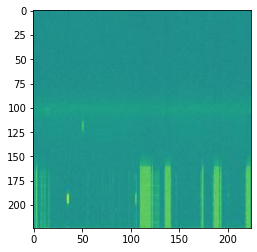

In [5]:
if feat_format =='IMG':
    plt.imshow(dataset.__getitem__(100)[0])

## Run Model

In [6]:
num_classes = len(dataset.unique_labels)
which_model = 'vgg' # or 'resnet'
if which_model == 'vgg':
    Model = VGGFC(num_classes)
elif which_model == 'resnet':
    Model = ResNetFC(num_classes)
elif which_model == '1dconv':
    Model = RFUAVNet(num_classes)

In [7]:
test_samp = dataset.__getitem__(40)[0]
test_samp = torch.unsqueeze(test_samp, 0)
Model(test_samp)

tensor([[ 0.2134,  0.3476, -0.1175, -0.1186, -0.2408, -0.1271,  0.2263]],
       grad_fn=<AddmmBackward0>)

In [8]:
# num_workers = 19
# train_val_test_split = [0.75, 0.05, 0.2]
# train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, (int(np.ceil(train_val_test_split[0]*len(dataset))), int(np.ceil(train_val_test_split[1]*len(dataset))), int(train_val_test_split[2]*len(dataset))))

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, num_workers=num_workers)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)


In [9]:
# Configuration options
k_folds = 5

batch_size = 128 # 128
learning_rate = 0.01
num_epochs = 10 # 0
momentum = 0.95
l2reg = 1e-4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:

trainedModel, res_acc, res_f1, res_runtime = runkfoldcv(Model, dataset, device, k_folds, batch_size, learning_rate, num_epochs, momentum, l2reg)

--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Linear(in_features=25088, out_features=7, bias=True)
Starting epoch 1


--------------------------------------------------------------------------------------------------------------